## Numerical analysis using Long Short Term Memory (LSTM) ##
### 1. import statements and prepare stock data from csv for training ###
This version uses pytorch to model close price of a stock. 5 yr of AAPL data is used in training 

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim

from datetime import datetime


In [202]:

prefix = datetime.today().strftime('%Y-%m-%d')
ticker= "AAPL" #"AAPL" #"^SPX" #"TSLA"

data = pd.read_csv(prefix+'-'+ticker+'.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2020-02-27,70.275002,71.500000,68.239998,68.379997,66.377548,320605600,AAPL
1,2020-02-28,64.315002,69.602501,64.092499,68.339996,66.338737,426510000,AAPL
2,2020-03-02,70.570000,75.360001,69.430000,74.702499,72.514923,341397200,AAPL
3,2020-03-03,75.917503,76.000000,71.449997,72.330002,70.211891,319475600,AAPL
4,2020-03-04,74.110001,75.849998,73.282501,75.684998,73.468651,219178400,AAPL
...,...,...,...,...,...,...,...,...
1249,2025-02-14,241.250000,245.550003,240.990005,244.600006,244.600006,40896200,AAPL
1250,2025-02-18,244.149994,245.179993,241.839996,244.470001,244.470001,48822500,AAPL
1251,2025-02-19,244.660004,246.009995,243.160004,244.869995,244.869995,32204200,AAPL
1252,2025-02-20,244.940002,246.779999,244.289993,245.830002,245.830002,32316900,AAPL


In [203]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

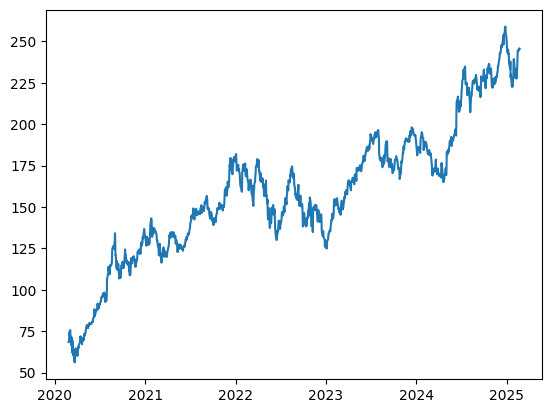

In [204]:
# only use close column
data = data[['Date', 'Close']]
pd.options.mode.chained_assignment = None
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [205]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

# construct dataframe with 7-day lookback
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)

## convert 7-day dataframe to array value between -1,1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data  = scaler.fit_transform(shifted_df.to_numpy())

scaled_data[0]

array([-0.8970075 , -0.840682  , -0.83109726, -0.80690148, -0.83996744,
       -0.81658473, -0.87929188, -0.87889765])

In [206]:
# define input X and label y
X = scaled_data[:, 1:] # last 7 columns are input
y = scaled_data[:, 0] # current close date is label

X = dc(np.flip(X, axis=1))

### 2. Split data into training and test sets with a 80/20 split ###


In [207]:
# set up train / test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


### 3. Convert the numpy arrays to PyTorch tensors ###
need to reshape, and add .to(device)

In [208]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([997, 7, 1]),
 torch.Size([250, 7, 1]),
 torch.Size([997, 1]),
 torch.Size([250, 1]))

In [209]:
# Create dataset object
train_ds = list(zip(X_train, y_train))
valid_ds = list(zip(X_test, y_test))
#
# Define the DataLoaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

for _, batch in enumerate(train_dl):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 7, 1]) torch.Size([64, 1])


### 4. Create and train model ###

In [210]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        # gate for lstm
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        lstm_out, _ = self.lstm(x, (h0,c0))  # LSTM output
        out = self.fc(lstm_out[:, -1, :])  # We take the last output
        return out

# Define hyperparameters
input_size = 1   # Number of features closing value for now
hidden_size = 4  # Number of hidden units in the LSTM
output_size = 1   # For 1 closing
num_stacked_layers = 4

# Initialize the model, loss, and optimizer
model = LSTMModel(input_size, hidden_size, num_stacked_layers, output_size).to(device)
criterion = nn.MSELoss()  # Mean square error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    ## train
    model.train(True)
    optimizer.zero_grad()
    running_loss = 0.0

    for batch_index, batch in enumerate(train_dl):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 5 == 0:  # print every 5 batches
            avg_loss_across_batches = running_loss / 10
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print(f"Epoch {epoch+1}/{epochs},  Loss: {loss.item()}")

    # validate
    model.train(False)
    running_loss = 0.0
    for batch_index, batch in enumerate(valid_dl):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()
    avg_loss = running_loss / len(valid_dl)
    print('Val Loss: {0:.3f}'.format(avg_loss))
    print('***************************************************')


Batch 1, Loss: 0.035
Batch 6, Loss: 0.154
Batch 11, Loss: 0.142
Batch 16, Loss: 0.129
Epoch 1/10,  Loss: 0.16299498081207275
Val Loss: 0.292
***************************************************
Batch 1, Loss: 0.020
Batch 6, Loss: 0.134
Batch 11, Loss: 0.133
Batch 16, Loss: 0.130
Epoch 2/10,  Loss: 0.26375362277030945
Val Loss: 0.268
***************************************************
Batch 1, Loss: 0.024
Batch 6, Loss: 0.118
Batch 11, Loss: 0.114
Batch 16, Loss: 0.123
Epoch 3/10,  Loss: 0.19575366377830505
Val Loss: 0.245
***************************************************
Batch 1, Loss: 0.018
Batch 6, Loss: 0.102
Batch 11, Loss: 0.118
Batch 16, Loss: 0.110
Epoch 4/10,  Loss: 0.17424635589122772
Val Loss: 0.229
***************************************************
Batch 1, Loss: 0.020
Batch 6, Loss: 0.104
Batch 11, Loss: 0.103
Batch 16, Loss: 0.101
Epoch 5/10,  Loss: 0.24676217138767242
Val Loss: 0.215
***************************************************
Batch 1, Loss: 0.021
Batch 6, Loss:

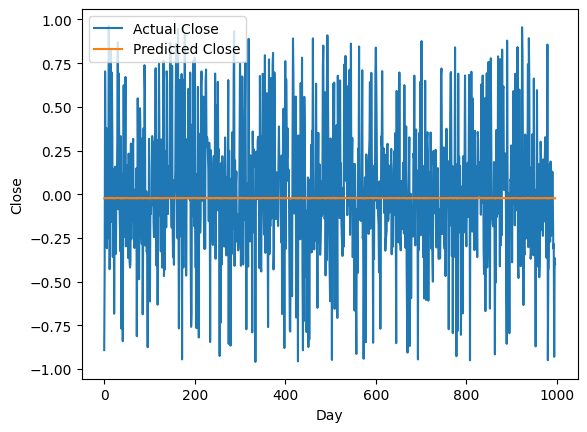

In [211]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
#y_train, predicted

C:\Users\joann\AppData\Local\Temp\ipykernel_20172\4165834649.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dummies[:, 0] = y_train.flatten()


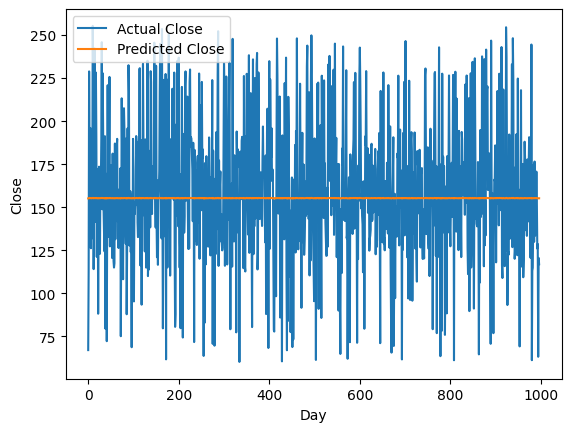

In [212]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
#new_y_train, train_predictions